
# 🛥️ **KMeans e DBSCAN** 🛥️
Este projeto utiliza técnicas de aprendizado de máquina para prever a sobrevivência de passageiros do Titanic, empregando KMeans e DBSCAN com dados fornecidos pelo Kaggle.

*   🗂️: Sistemas Inteligentes (IF684 - EC)
*   **Grupo 2 - Integrantes**
  - Bianca Duarte Santos (bds)
  - Dara Caroline de Souza Vasconcelos (dcsv)
  - Maria Eduarda Nunes de Almeida (mena)
  - Rafael da Silva Barros (rsb7)
  - Yasmim Vitória Silva de Oliveira (yvso)


## Bibliotecas

In [ ]:
! pip install optuna
! pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tabulate import tabulate, tabulate_formats

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as skl_silhouette_score
from sklearn.metrics import accuracy_score, davies_bouldin_score

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, KFold, StratifiedKFold
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from copy import deepcopy


from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import RandomOverSampler



## Github repositório Titanic-db

In [ ]:
! git clone https://github.com/yasmimvso/titanic-db.git

Cloning into 'titanic-db'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 33.25 KiB | 1.75 MiB/s, done.


In [ ]:
file = "/content/titanic-db/titanic/train.csv"

db_titanic =  pd.read_csv(file)


## Functions



In [ ]:
def has_relationship(x):
  return 0 if x == 0 else 1

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

def intra_cluster_distances(X, labels):
    unique_labels = np.unique(labels)
    intra_dists = {}
    for label in unique_labels:
        if label == -1:  # Ignora o ruído no DBSCAN
            continue
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            dists = pairwise_distances(cluster_points)
            intra_dists[label] = np.mean(dists)
        else:
            intra_dists[label] = 0  # Clusters com um único ponto têm distância intra-cluster zero
    return intra_dists

In [ ]:
def inter_cluster_distances_no_media(X, labels):
    unique_labels = np.unique(labels)
    cluster_centroids = {}

    # Calcula os centróides dos clusters
    for label in unique_labels:
        if label == -1:  # Ignora o ruído no DBSCAN
            continue
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        cluster_centroids[label] = centroid

    if len(cluster_centroids) < 2:
        return {}  # Não há clusters suficientes para calcular distâncias inter-cluster

    # Calcula as distâncias entre todos os pares de centroides
    centroid_labels = list(cluster_centroids.keys())
    centroids = np.array([cluster_centroids[label] for label in centroid_labels])
    dist_matrix = pairwise_distances(centroids)

    # Cria o dicionário de distâncias inter-cluster
    inter_dists = {}
    for i in range(len(centroid_labels)):
        for j in range(i + 1, len(centroid_labels)):
            cluster1 = centroid_labels[i]
            cluster2 = centroid_labels[j]
            distance = dist_matrix[i, j]
            if cluster1 not in inter_dists:
                inter_dists[cluster1] = []
            if cluster2 not in inter_dists:
                inter_dists[cluster2] = []
            inter_dists[cluster1].append(distance)
            inter_dists[cluster2].append(distance)

    return inter_dists

In [ ]:
def inter_cluster_distances(X, labels):
    unique_labels = np.unique(labels)
    cluster_centroids = []
    for label in unique_labels:
        if label == -1:  # Ignora o ruído no DBSCAN
            continue
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        cluster_centroids.append(centroid)

    if len(cluster_centroids) < 2:
        return 0  # Não há clusters suficientes para calcular distâncias inter-cluster

    centroids_dists = pairwise_distances(cluster_centroids)
    inter_dist = np.mean(centroids_dists)
    return inter_dist

In [ ]:
def normalize_fare(fare):
    if fare < 100 :
        return 0
    elif fare >= 100 and fare < 200 :
        return 0.5
    else:
        return 1

In [ ]:
def inertia_kmeans(X):
    print("Relação de valores de inércia e números de clusters")
    for i in range(1, 15):
        model = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(X)
        print(f"Clusters: {i}, Inertia: {model.inertia_}")

In [ ]:
def ellbow_graph(model):

  k_values= []
  inertias= []

  for i in range(1,15):
    model = KMeans(n_clusters=i, n_init='auto').fit(X)
    k_values.append(i)
    inertias.append(model.inertia_)

  fig, ax = plt.subplots()
  ax.plot(k_values, inertias)
  plt.title('Ellbow Graph')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')

  plt.show()

In [ ]:
def indice_rand(y, k, kmeans):
  ## kmeans == é o modelo treinado para avaliar a quantidade de K
  ## o valor vai entre o e 1

  print(f"Resltado de indice de rand com {k} clusters")
  result = metrics.adjusted_rand_score(y, kmeans.labels_)
  print(result)


In [ ]:
def dbscan_score(labels, X):

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print('Número estimado de clusters: %d' % n_clusters_)
  print('Número estimado de pontos de ruído: %d' % n_noise_)
  print("Coeficiente de Silhueta: %0.3f" % metrics.silhouette_score(X, labels))


In [ ]:
import math

def bic_score(X: np.ndarray, labels: np.array):
  """
  BIC score for the goodness of fit of clusters.
  This Python function is translated from the Golang implementation by the author of the paper.
  The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
  """

  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2

  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

  return bic

In [ ]:
def davies_bouldin(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""

  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return davies_bouldin_score(X, labels)


In [ ]:
def silhouette(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""

  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return skl_silhouette_score(X, labels)

In [ ]:
def plot_scores(X):
  # Métricas de avaliação para K-means
  scores = {'k': [], 'silhouette': [], 'calinski_harabasz': [], 'davies_bouldin': []}
  for k in range(2, 11):
      kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
      labels = kmeans.fit_predict(X)

      scores['k'].append(k)
      scores['silhouette'].append(skl_silhouette_score(X, labels))
      scores['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
      scores['davies_bouldin'].append(davies_bouldin_score(X, labels))

  scores_df = pd.DataFrame(scores)
  print(scores_df)
  fig, ax = plt.subplots(3, 1, figsize=(10, 15))

  #plotar graficos
  sns.lineplot(data=scores_df, x='k', y='silhouette', ax=ax[0])
  ax[0].set_title('Silhouette Score vs Número de Clusters')

  sns.lineplot(data=scores_df, x='k', y='calinski_harabasz', ax=ax[1])
  ax[1].set_title('Calinski-Harabasz Score vs Número de Clusters')

  sns.lineplot(data=scores_df, x='k', y='davies_bouldin', ax=ax[2])
  ax[2].set_title('Davies-Bouldin Score vs Número de Clusters')

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.decomposition import PCA

def plot_graph_centroid(X, labels, features):


# Aplicando PCA para reduzir as dimensões
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(X)

  # Obtendo os centróides transformados
  centroids = pca.transform(kmeans.cluster_centers_)

  # Configuração do gráfico 2D
  plt.figure(figsize=(10, 7))
  plt.title('Clusterização com K-means')
  plt.xlabel('PC1')
  plt.ylabel('PC2')

  # Plotando os pontos de dados e centróides
  plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5, edgecolor='k', s=50)
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, linewidths=2, label='Centroids')

  # Exibindo a legenda e o gráfico
  plt.legend()
  plt.show()


# Análise de Dados

## Análise Geral

| Feature                                       | Variable    | Value Type                                       |   |
|-----------------------------------------------|-------------|--------------------------------------------------|---|
| Index (Starting from 1)                    | PassangerId | int
| Survival    (Target Variable)                         | Survived | binary
|Ticket Class | Pclass | 1: 1st; 2: 2nd; 3: 3rd
|Sex	| Sex	| categorical code (female or male)
|Age | Age | float(years)
| Number of Sibilings/spouses* | Sibsp | int
| Number of parents/children** | Parch | int
| Ticket |	Ticket | int
| Amount paid for the ticket	| Fare | float
|Cabin |	Cabin | string
| Port of Embarkation | Embarked	| categorial code (C: Cherbourg, Q: Queenstown, S: Southampton)

### Observações
Age:  A idade é fracionada se for menor que 1. Se a idade for estimada, está na forma de xx.5
#### Relações Familiares
O dataset define relações famiiares da seguinte forma:
<br>
- \* Sibilings: irmão, irmã, meio-irmão, meia-irmã
<br>
- \** Spouses: marido, esposa (amantes e noivos foram ignorados)
<br>
-  Parent: mãe, pai
-  Child: filha, filho, enteada, enteado
<br>
Algumas crianças viajaram apenas com uma babá, portanto parch=0 para elas.

In [ ]:
display(db_titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
#Análise Estatística dos Dados
db_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
print('Tipos de Dados:')
db_titanic.info()

print('\nNúmero de linhas e colunas:')
db_titanic.shape

Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Número de linhas e colunas:


(891, 12)

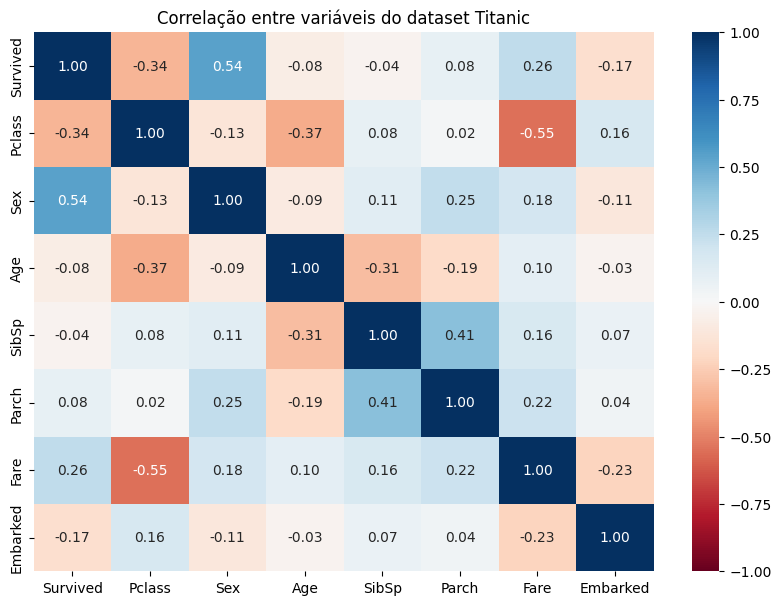

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
df  = db_titanic
#Excluir variáveis categoricas
df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
#Converter male para 0 e female para 1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
#Converter Embarked para 0, 1, 2
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
sns.heatmap(df.corr(),
            annot = True,
            fmt = '.2f',
            cmap='RdBu',
            vmin = -1.0,
            vmax = 1.0
            )
plt.title('Correlação entre variáveis do dataset Titanic')
plt.show()

In [ ]:
#Verificar a existência de valores nulos
db_titanic.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Percebemos a presença de valores nulos em Embarked, Cabin e Age. Tomaremos as seguintes atitudes na Limpeza de Dados:
* A quantidade de valores nulos em Cabin é alta (77% da coluna em falta), logo, essa variável não será tão impactante no problema. Iremos removê-la.
* Para Embarked, apenas duas linhas tem valores nulos. Vamos eliminá-las.
* Para Age, 177 valores faltantes (19,86%). Por isso, vamos estimar esses valores. Utilizamos Regressão Linear para fazê-lo.

In [ ]:
print('Nome das colunas:')
db_titanic.columns

Nome das colunas:


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Análise Exploratória

### Variáveis Numéricas

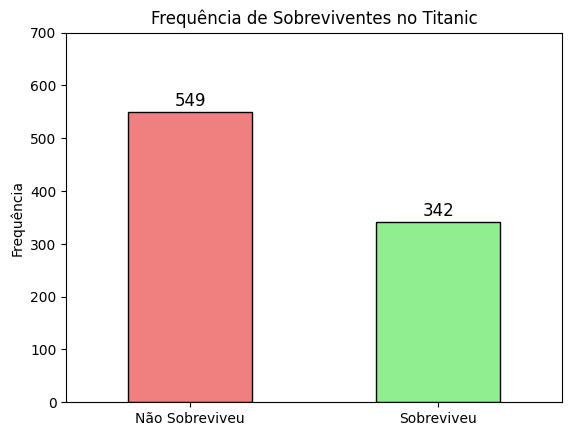

In [ ]:
# Contar a frequência de sobreviventes e não sobreviventes
survival_counts = db_titanic['Survived'].value_counts()

# Criar o gráfico de barras com cores mais leves
colors = ['lightcoral', 'lightgreen']
ax = survival_counts.plot(kind='bar', color=colors, edgecolor='black')

# Adicionar os valores em cada barra com um tamanho maior de fonte
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points', fontsize=12)

# Configurar o título
plt.title('Frequência de Sobreviventes no Titanic')
plt.xticks(ticks=[0, 1], labels=['Não Sobreviveu', 'Sobreviveu'], rotation=0)
plt.ylabel('Frequência')
plt.ylim(0, 700)

# Remover o rótulo do eixo x
ax.set_xlabel('')

#plt.figure(figsize=(14, 10))

plt.show()


In [ ]:

fig = make_subplots (rows=4, cols=1) #cria espaço com 4 linhas
fig.add_trace(go.Box(x=db_titanic['Age'], name = 'Idade'), row=1, col=1) #cria na primeira linha um boxplot sobre a idade dos pacientes
fig.add_trace(go.Box(x=db_titanic['SibSp'], name = 'Número de Irmãos/Conjuges'), row=2, col=1)
fig.add_trace(go.Box(x=db_titanic['Fare'], name = 'Valor do Bilhete'), row=3, col=1)
fig.add_trace(go.Box(x=db_titanic['Parch'], name = 'Número de Pais/Filhos'), row=4, col=1)
fig.update_layout(height = 800, template='plotly_dark')
fig.show()

###**Interpretação do BloxPlot**



1.   Idade (Idade):


*   Mediana: A mediana da idade está por volta dos 30 anos.
*   Quartis: O primeiro quartil (Q1) está por volta dos 20 anos, e o terceiro quartil (Q3) está por volta dos 40 anos.
*   Outliers: Existem alguns outliers em idades mais avançadas, especialmente acima de 70 anos.
*   Interpretação: A maioria dos passageiros tinha entre 20 e 40 anos, com poucos passageiros muito jovens ou muito idosos.


2.   Número de Irmãos/Cônjuges (SibSp):


*   Mediana: A mediana é 0, indicando que a maioria dos passageiros não estava viajando com irmãos ou cônjuges.
*   Quartis: O primeiro quartil é 0 e o terceiro quartil é 1.
*   Outliers: Existem vários outliers que indicam passageiros viajando com mais de 3 irmãos/cônjuges.
*   Interpretação: A maioria dos passageiros viajava sozinha ou com no máximo uma outra pessoa (irmão ou cônjuge), mas alguns viajavam com famílias maiores.

3. Valor do Bilhete (Fare):


*   Mediana: A mediana do valor do bilhete é bastante baixa, sugerindo que a maioria dos passageiros pagou menos de 100 unidades monetárias.
*   Quartis: O primeiro quartil é próximo de 0, e o terceiro quartil está abaixo de 100.
*   Outliers: Existem muitos outliers que pagaram acima de 200 unidades monetárias, chegando até mais de 500.
*   Interpretação: A maioria dos passageiros pagou pouco pelo bilhete, mas houve alguns que pagaram muito mais, indicando diferenças significativas nas condições de viagem (provavelmente classes diferentes).

4. Número de Pais/Filhos (Parch):


*   Mediana: A mediana é 0, indicando que a maioria dos passageiros não estava viajando com pais ou filhos.
*   Quartis: O primeiro quartil é 0 e o terceiro quartil é 0, indicando que 75% dos passageiros não estavam viajando com pais ou filhos.
*   Outliers: Existem alguns outliers com até 5 ou 6 pais/filhos.
*   Interpretação: A maioria dos passageiros não estava viajando com pais ou filhos, mas alguns viajavam com famílias mais numerosas.



##**Interpretações Gerais:**
Distribuição Etária: A maioria dos passageiros estava na faixa etária de 20 a 40 anos.
Estrutura Familiar: Muitos passageiros viajavam sozinhos ou apenas com um irmão/cônjuge, e poucos viajavam com pais ou filhos.
Custo da Viagem: O custo do bilhete variava amplamente, com a maioria pagando valores baixos e alguns pagando quantias significativamente mais altas.
Outliers: A presença de outliers em todas as variáveis sugere que havia uma diversidade significativa entre os passageiros em termos de idade, estrutura familiar e capacidade de pagar pela viagem.


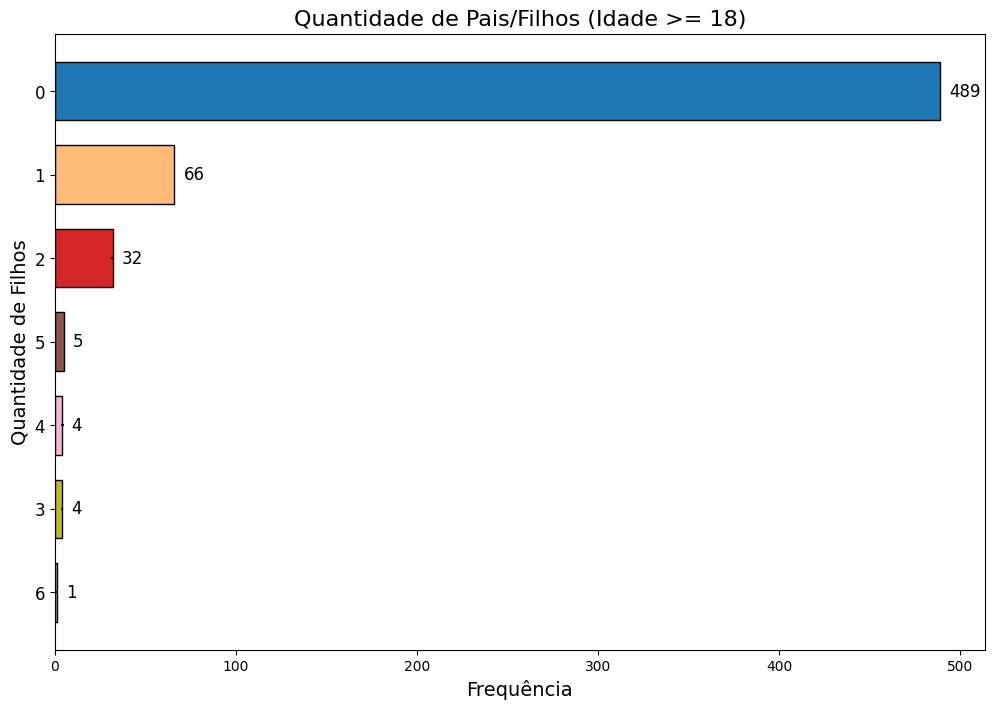

In [ ]:


# Filtra os valores onde 'Age' é maior ou igual a 20.00
filtered_data = db_titanic.loc[db_titanic['Age'] >= 18.00]

# obtém a contagem de ocorrências de cada valor único na coluna "Parch"
contagem = filtered_data['Parch'].value_counts()

# separa os valores únicos e as contagens em listas separadas
valores_unicos = contagem.index.tolist()
frequencia = contagem.tolist()

# Example data
y_pos = np.arange(len(valores_unicos))
performance = contagem.tolist()
error = np.random.rand(len(valores_unicos))

# Cores diferentes para cada barra
colors = plt.cm.tab20(np.linspace(0, 1, len(valores_unicos)))



plt.figure(figsize=(12, 8))  # Aumenta o tamanho da figura
bars = plt.barh(y_pos, performance, xerr=error, align='center', height=0.7, color=colors, edgecolor='black')  # Muda a cor das barras

plt.yticks(y_pos, labels=valores_unicos, fontsize=12)
plt.gca().invert_yaxis()  # Inverte o eixo y
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Quantidade de Filhos', fontsize=14)
plt.title('Quantidade de Pais/Filhos (Idade >= 18)', fontsize=16)

# Adiciona os valores das frequências nas barras
for bar, value in zip(bars, performance):
    x_position = bar.get_width() + 5
    alignment = 'left'
    color = 'black'
    plt.text(x_position, bar.get_y() + bar.get_height()/2, str(value), ha=alignment, va='center', fontsize=12, color=color)

#plota o gráfico de barras

plt.show()


### Dados categóricos


In [ ]:
# Verificar os valores únicos e suas contagens na coluna 'Pclass'
print(db_titanic['Pclass'].value_counts())
print(db_titanic['Sex'].value_counts())
print(db_titanic['Embarked'].value_counts())
print(db_titanic['Survived'].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Survived
0    549
1    342
Name: count, dtype: int64


In [ ]:
fig = make_subplots (rows=3, cols=1)
fig.add_trace(go.Bar(y= db_titanic['Pclass'].value_counts(), x = ['3ª classe', '1ª classe', '2ª classe'], name='Classe'), row=1, col=1)
fig.add_trace(go.Bar(y= db_titanic['Sex'].value_counts(), x = ['Masculino', 'Feminino'], name='Sexo'), row=2, col=1)
fig.add_trace(go.Bar(y= db_titanic['Embarked'].value_counts(), x = ['Southampton', 'Cherbourg', 'Queenstown'], name='Portão de Embarque'), row=3, col=1)
fig.update_layout(
    title={
        'text': "Análise de Variáveis Categóricas",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    template='plotly_dark',
    height=800,
    width=1000
)
fig.show()

In [ ]:
print(db_titanic.groupby(['Pclass', 'Survived']).count()['PassengerId'])
print(db_titanic.groupby(['Sex', 'Survived']).count()['PassengerId'])
print(db_titanic.groupby(['Embarked', 'Survived']).count()['PassengerId'])

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: PassengerId, dtype: int64
Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: PassengerId, dtype: int64
Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           217
Name: PassengerId, dtype: int64


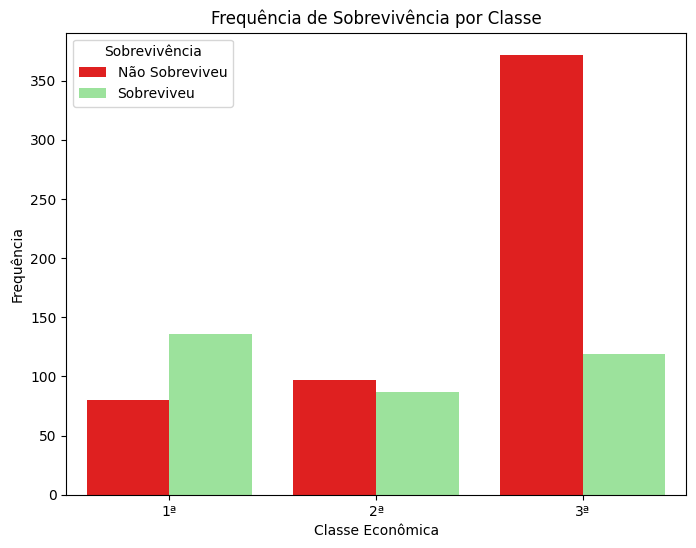

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Pclass', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Classe")
plt.xlabel('Classe Econômica')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1, 2], labels=['1ª', '2ª', '3ª'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

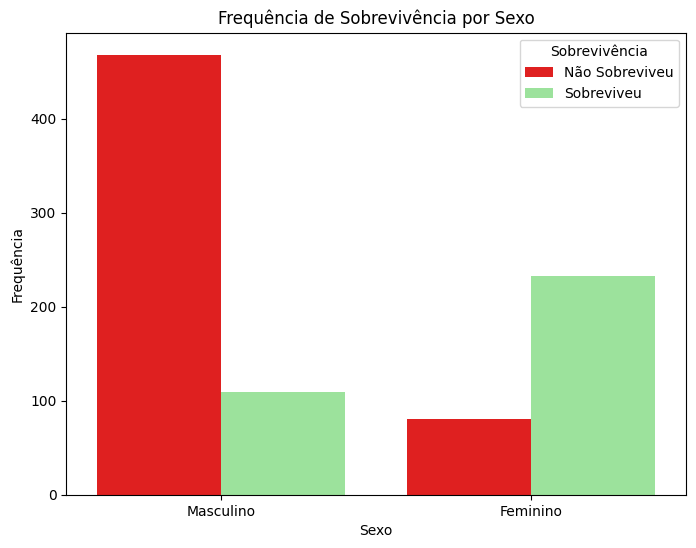

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Sex', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Sexo")
plt.xlabel('Sexo')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1], labels=['Masculino', 'Feminino'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

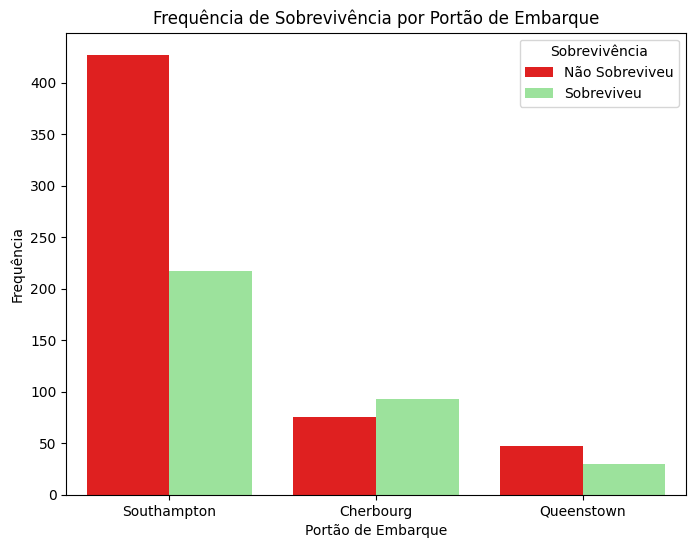

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=db_titanic, x='Embarked', hue='Survived', palette={0: 'red', 1: 'lightgreen'})

plt.title("Frequência de Sobrevivência por Portão de Embarque")
plt.xlabel('Portão de Embarque')
plt.ylabel("Frequência")

plt.xticks(ticks=[0, 1, 2], labels=[ 'Southampton', 'Cherbourg', 'Queenstown'])
plt.legend(title='Sobrevivência', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic

# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0.0, 18.0, 60.0, age_max]  # max() + 1 para incluir o valor máximo no último bin
labels = ['Não Adulto', 'Adulto', 'Não Adulto']

# Categorizar idades
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, ordered=False)

# Bebês, Crianças, Adolescentes e Idosos -> Não Adultos
#df['AgeClass'] = df['AgeClass'].replace(['Bebês', 'Crianças', 'Adolescentes', 'Idosos'], 'Não Adultos')
#df[''] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência entre Adultos e Não-Adultos por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Definir classes de idade
bins = [0, 18, 30, 60, df['Age'].max()]
labels = ['Não Adultos', 'Adultos 18-30', 'Adultos 30-60', 'Não Adultos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Não Adultos e Adultos (com 2 faixas) por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Definir classes de idade
bins = [0, 18, 30, 40, 50, 60, df['Age'].max()]
labels = ['Não Adultos', 'Adultos 18-30', 'Adultos 30-40', 'Adultos 40-50', 'Adultos 50-60', 'Não Adultos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Não Adultos e Adultos (com 4 faixas) por Sexo",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = db_titanic
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0, 2, 12, 17, 59, age_max]
labels = ['Bebês', 'Crianças', 'Adolescentes', 'Adultos', 'Idosos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeClass'].value_counts().index,
                         y=sub_df['AgeClass'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Sexo e 5 Faixas de Idade",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


df = db_titanic.copy()
# Remover valores faltantes na coluna 'Age' e 'Survived'
df = df.dropna(subset=['Age', 'Survived']).copy()

# Calcular os valores máximos e mínimos da idade
age_min = df['Age'].min()
age_max = df['Age'].max()

# Definir classes de idade
bins = [0, 2, 12, 17, 59, age_max]
labels = ['Bebês', 'Crianças', 'Adolescentes', 'Adultos', 'Idosos']
df['AgeClass'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Reagrupar as classes de idade em três categorias: "Crianças+Bebês", "Idosos+Adolescentes" e "Adultos"
df['AgeGroup'] = df['AgeClass'].replace({
    'Bebês': 'Crianças+Bebês',
    'Crianças': 'Crianças+Bebês',
    'Adolescentes': 'Idosos+Adolescentes',
    'Idosos': 'Idosos+Adolescentes'
})

# Criar subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=("Distribuição Geral", "Distribuição por Sexo: Masculino", "Distribuição por Sexo: Feminino"))

# Gráfico 1: Distribuição geral
for survived in [0, 1]:
    sub_df = df[df['Survived'] == survived]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red'),
                  row=1, col=1)

# Gráfico 2: Distribuição por sexo masculino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'male')]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=2, col=1)

# Gráfico 3: Distribuição por sexo feminino
for survived in [0, 1]:
    sub_df = df[(df['Survived'] == survived) & (df['Sex'] == 'female')]
    fig.add_trace(go.Bar(x=sub_df['AgeGroup'].value_counts().index,
                         y=sub_df['AgeGroup'].value_counts().values,
                         name=f'Sobreviveu: {survived}',
                         marker_color='lightgreen' if survived == 1 else 'red',
                         showlegend=False),
                  row=3, col=1)

# Ajustar layout
fig.update_layout(title_text="Frequência de Sobrevivência por Sexo e Classes de Idade Agrupadas",
                  height=800, width=800)
fig.update_xaxes(title_text="Classe de Idade", row=1, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=2, col=1)
fig.update_xaxes(title_text="Classe de Idade", row=3, col=1)
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)
fig.update_yaxes(title_text="Frequência", row=3, col=1)

# Mostrar figura
fig.show()


# Engenharia de Dados


 -- Limpeza de dados:

 * A limpeza de dados foi utilizado para analizar os dados faltantes e corrompidos. Optamos por excluir a coluna Cabin, Ticket, Name, PassagerID por se tratar de dados com muito dados faltantes ou irrelevantes para o modelo

 * Por se tratar de um modelo de classificação de árvore, normalizamos os dados e os transformamos em numérico. Passo importante para o trainamento do modelo.

In [ ]:
# Seleção de informações mais relevantes em traino

db_titanic = db_titanic.drop('Cabin', axis=1)
db_titanic = db_titanic.drop('Ticket', axis=1)
db_titanic = db_titanic.drop('Name', axis=1)
db_titanic = db_titanic.drop('PassengerId', axis=1)

# transformando de dados categóricos para numericos
db_titanic['Sex'] =  db_titanic['Sex'].map({'male': 0, 'female': 1})
db_titanic['Embarked'] =  db_titanic['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})
# titanic_feature['Age'] = titanic_feature['Age'] /titanic_feature['Age'].abs().max()
# db_titanic['Pclass'] = db_titanic['Pclass'].map({1: 0, 2: 0.5, 3: 1})

db_titanic=  db_titanic[~db_titanic['Embarked'].isnull()] ## tirando as linhas corrompidas de Embarque

# Irei apenas fromatar SibSp e Parch de modo a destacar que tenha ou não relaçaõ com os parametros
# se tem alguma relação 1, caso contrário 0

db_titanic['SibSp'] =  db_titanic['SibSp'].apply(has_relationship)

db_titanic['Parch'] = db_titanic['Parch'].apply(has_relationship)

## Tratando variáveis

Essa opção, considera a escolha dos tratamentos de Parch e SibSp

In [ ]:
data_X = db_titanic[~db_titanic['Age'].isnull()][['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fare', 'Survived']]

data_y = db_titanic[~db_titanic['Age'].isnull()][['Age']]

data_pred = db_titanic[db_titanic['Age'].isnull()][['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fare', 'Survived']]

###### KNN

O KNN pode ser utilizado tanto para regressão assim como para classificação. É utilizado os K valores mais próximos do que se deseja prever. É um modelo preguiçoso, para datasets muito grandes pode ser custoso.

É recomendável trabalhar com variáveis com escalas próximas

In [ ]:
# separar os dados em com valorres de Age e sem Valores de Age
# TENHO QUE ANALISAR MELHOR COMO DEFINIR OS K VIZINHOS. QUALMELHOR VALOR PRA ISSO
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(data_X, data_y)

# Fazendo a predição
result = neigh.predict(data_pred)

## substituindo valores corrompidos com os preditos
db_titanic.loc[db_titanic['Age'].isnull(), 'Age'] = np.round(result)

print(result)
print(db_titanic.isnull().sum())
print("total de valores preditos", len(result))

[[47.8  ]
 [36.3  ]
 [17.2  ]
 [32.8  ]
 [17.6  ]
 [30.8  ]
 [21.584]
 [17.6  ]
 [24.6  ]
 [28.7  ]
 [26.   ]
 [33.2  ]
 [17.6  ]
 [25.4  ]
 [36.8  ]
 [38.6  ]
 [19.8  ]
 [30.8  ]
 [26.   ]
 [17.6  ]
 [26.   ]
 [26.   ]
 [30.8  ]
 [31.2  ]
 [25.6  ]
 [26.   ]
 [47.8  ]
 [24.8  ]
 [20.4  ]
 [22.1  ]
 [26.8  ]
 [36.6  ]
 [35.8  ]
 [55.6  ]
 [36.1  ]
 [38.4  ]
 [27.6  ]
 [46.8  ]
 [26.   ]
 [47.8  ]
 [17.6  ]
 [36.6  ]
 [47.8  ]
 [30.8  ]
 [29.4  ]
 [26.6  ]
 [19.9  ]
 [26.   ]
 [22.1  ]
 [47.2  ]
 [47.8  ]
 [32.   ]
 [44.8  ]
 [17.6  ]
 [36.6  ]
 [55.6  ]
 [38.6  ]
 [48.6  ]
 [17.6  ]
 [29.2  ]
 [27.9  ]
 [26.   ]
 [29.   ]
 [36.6  ]
 [28.   ]
 [40.4  ]
 [30.8  ]
 [24.6  ]
 [50.4  ]
 [32.8  ]
 [17.6  ]
 [17.6  ]
 [33.2  ]
 [17.2  ]
 [17.6  ]
 [36.4  ]
 [30.8  ]
 [42.7  ]
 [29.4  ]
 [30.8  ]
 [40.1  ]
 [36.6  ]
 [22.8  ]
 [28.7  ]
 [22.1  ]
 [47.8  ]
 [24.6  ]
 [26.   ]
 [25.4  ]
 [26.   ]
 [45.   ]
 [47.8  ]
 [26.   ]
 [36.6  ]
 [42.7  ]
 [22.1  ]
 [44.4  ]
 [36.6  ]
 [29.4  ]
 [25.4  ]


##### Tratamento de idade com média e inclusão de coluna missing

In [ ]:

## criaando nova coluna 'Missing' referenciando as idades faltantes

db_titanic['Missing'] = db_titanic['Age'].isnull().astype(int)

# Linhas de treino e target serão
age_min = db_titanic['Age'].min()
age_max = db_titanic['Age'].max()
age_mean = (age_max + age_min) / 2

db_titanic['Age'] = db_titanic['Age'].fillna(age_mean)

display(db_titanic)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Missing
0,0,3,0,22.0,1,0,7.2500,3.0,0
1,1,1,1,38.0,1,0,71.2833,1.0,0
2,1,3,1,26.0,0,0,7.9250,3.0,0
3,1,1,1,35.0,1,0,53.1000,3.0,0
4,0,3,0,35.0,0,0,8.0500,3.0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,3.0,0
887,1,1,1,19.0,0,0,30.0000,3.0,0
888,0,3,1,27.0,1,1,23.4500,3.0,0
889,1,1,0,26.0,0,0,30.0000,1.0,0


##### Regressão Linear


Consideramos a identificação a predição de retas que melhor se aproxima de pontos. É feito várias contas matemáica para melhor estimar uma reta. Faz minimizando a soma dos erros ao quadrado, a partir disso busca a reda que menor minimiza o erro. E é feito a análise do erro entre a comparação do valores observados e os que estão prevendo. Como existe muitas variáveis independentes. Será utilizado regressão liner múltipla

In [ ]:
reg = LinearRegression()
reg.fit(data_X, data_y)

pred = reg.predict(data_pred)

db_titanic.loc[db_titanic['Age'].isnull(), 'Age'] = np.round(np.abs(pred))

print(np.round(np.abs(pred)))
print(db_titanic.isnull().sum())
print("total de valores preditos" , len(pred))

##### Agrupamentos de "Age" pós tratamento

Agrupamento de Idade em Não adulto / Adulto 18-30 / Adulto 30 - 60 / Idosos mais velhos

In [ ]:
bins = [0, 18, 30, 60, db_titanic['Age'].max() + 1]
labels = ['Não Adultos', 'Adultos 18-30', 'Adultos 30-60', 'Não Adultos']
db_titanic['Age'] = pd.cut(db_titanic['Age'], bins=bins, labels=labels, include_lowest=True, right=False, ordered=False)


db_titanic['Age']= db_titanic['Age'].apply(lambda x: 0 if x == 'Não Adultos' else 1 if x == 'Adultos 18-30' else 2)


db_titanic = db_titanic[~db_titanic['Age'].isnull()]

db_titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Missing
0,0,3,0,1,1,0,7.2500,3.0,0
1,1,1,1,2,1,0,71.2833,1.0,0
2,1,3,1,1,0,0,7.9250,3.0,0
3,1,1,1,2,1,0,53.1000,3.0,0
4,0,3,0,2,0,0,8.0500,3.0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,0,13.0000,3.0,0
887,1,1,1,1,0,0,30.0000,3.0,0
888,0,3,1,1,1,1,23.4500,3.0,0
889,1,1,0,1,0,0,30.0000,1.0,0


## Tratando Desbalanceamento

Utilizamento da bilioteca imbalanced do sklearning para balancear o modelo.

Funções de Balanceamento :

* SMOTE
* RANDON SAMPLE

Nos modelos, esse agrupamento teste se mostrou insatisfatório. Não o utilizamos como resultado final.

In [ ]:
filtered_titanic_feature = db_titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Fare']]
filtered_titanic_target= db_titanic['Survived']

### Randon Oversample

Essa função visa os dados de minoria, tendendo aumentar de forma aleatória o dado de menoria para 1:1 com o dado de maioria

In [ ]:
## quando faz o oversample os valores ficam comrrompidos

ros =  RandomOverSampler(sampling_strategy = 'not majority')
titanic_feature , titanic_target = ros.fit_resample(filtered_titanic_feature, filtered_titanic_target)

ax = titanic_target.value_counts()
print(ax)


Survived
0    549
1    549
Name: count, dtype: int64


In [ ]:
titanic_feature

,Pclass,Sex,Age,SibSp,Parch,Embarked,Fare
0,3,0,1,1,0,3.0,7.2500
1,1,1,2,1,0,1.0,71.2833
2,3,1,1,0,0,3.0,7.9250
3,1,1,2,1,0,3.0,53.1000
4,3,0,2,0,0,3.0,8.0500
...,...,...,...,...,...,...,...
1093,2,1,2,0,0,3.0,13.5000
1094,3,1,1,0,0,3.0,9.8417
1095,1,0,2,0,0,3.0,30.5000
1096,2,0,0,0,1,3.0,29.0000


# Tunando Hiperparametro

## K-Means

**Parâmetros de análise:**
- **n_clusters:** Número de clusters e centroides a serem definidos pelo algoritmo.
- **init:** Método de inicialização do algoritmo:
  - **k-means++:** Seleciona o centro inicial dos clusters de forma inteligente para otimizar o processo de convergência.
  - **random:** Escolhe aleatoriamente `n_clusters` observações dos dados para definir os centroides iniciais.
- **n_init:** Número de vezes que o algoritmo executará com amostras de centroides diferentes. Os resultados finais serão os melhores obtidos de `n_init` execuções em termos de inércia.
- **tol:** Tolerância relativa com relação à norma de Frobenius da diferença entre os centroides do cluster em duas iterações consecutivas para declarar convergência. A norma de Frobenius é calculada com a seguinte fórmula:

  $\lVert A\rVert _F = \sqrt{∑^m_{i=1}\sum^n_{j=1}\rvert a_{ij}\lvert}$

  O algoritmo executa até que a alteração da norma seja menor que o valor de tolerância. Assim, se `tol` possuir um valor mais alto, a tolerância de variação da norma será mais baixa, o que implica que o algoritmo pode interromper sua execução sem percorrer todo o espaço de características e concluir o número de iterações especificado.
- **algorithm:** Algortimo de k-means a ser usado.
  - **lloyd:** Algoritmo clássico ao estilo Expectativa-Maximização (EM).
  - **elkan:** Variação mais eficiente para datasets com clusters bem definidos, que utiliza desigualdade triangular. Porém, demanda maior capacidade de memória.

### Definindo intervalos de parâmetros

In [ ]:
# Possibilidades de valores para os parâmetros
# usadas no Grid Search
params_dist = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [1, 5, 10],
    'tol': [1.0e-4, 1.0e-3, 1.0e-2],
    'algorithm': ['lloyd', 'elkan']
    }

### Grid Search

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate(model, X_train):
  # Função de treino dos modelos gerados
  # pelo Grid Search
  model.fit(X_train)

def scorer(estimator, X_train):
  clusters = estimator.fit_predict(X_train)
  distance_matrix = pairwise_distances(X_train)
  score = skl_silhouette_score(distance_matrix, clusters)
  return score

def get_best_results(dict):
  # Função para pegar os melhores resultados do Grid Search
  for i in range(10):
    for j in range(len(grid_search_kmeans.cv_results_['rank_test_score'])):
      if grid_search_kmeans.cv_results_['rank_test_score'][j] == i+1:
        results['rank_score'].append(grid_search_kmeans.cv_results_['rank_test_score'][j])
        results['n_clusters'].append(grid_search_kmeans.cv_results_['param_n_clusters'][j])
        results['init'].append(grid_search_kmeans.cv_results_['param_init'][j])
        results['n_init'].append(grid_search_kmeans.cv_results_['param_n_init'][j])
        results['tol'].append(grid_search_kmeans.cv_results_['param_tol'][j])
        results['algorithm'].append(grid_search_kmeans.cv_results_['param_algorithm'][j])
        results['mean_test_score'].append(grid_search_kmeans.cv_results_['mean_test_score'][j])
  return results

In [ ]:
# Criando o algoritmo K-Means
kmeans = KMeans()

# Gerando o otimizador baseado no Grid Search
grid_search_kmeans = GridSearchCV(
    estimator=kmeans,
    param_grid=params_dist,
    scoring=scorer,
    refit=False,
    verbose=1
)

# Chamando função de treino
evaluate(grid_search_kmeans, data_X)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [ ]:
# Resultados da inferência com Grid Search
results = {
    'rank_score': [],
    'n_clusters': [],
    'init': [],
    'n_init': [],
    'tol': [],
    'algorithm': [],
    'mean_test_score': []
}

# Recuperando e apresentando os resultados mais otimizados do Grid Search
best_results = get_best_results(grid_search_kmeans.cv_results_)
# print(tabulate(grid_search_kmeans.cv_results_, headers='keys', tablefmt='outline'))
print(tabulate(best_results, headers='keys', tablefmt='outline'))

+--------------+--------------+-----------+----------+--------+-------------+-------------------+
|   rank_score |   n_clusters | init      |   n_init |    tol | algorithm   |   mean_test_score |
+==============+==============+===========+==========+========+=============+===================+
|            1 |            2 | k-means++ |        1 | 0.0001 | lloyd       |          0.862852 |
|            2 |            2 | k-means++ |        1 | 0.01   | elkan       |          0.862021 |
|            3 |            2 | k-means++ |        1 | 0.001  | elkan       |          0.85555  |
|            4 |            2 | random    |        5 | 0.01   | lloyd       |          0.852624 |
|            5 |            2 | k-means++ |        5 | 0.01   | lloyd       |          0.847978 |
|            5 |            2 | k-means++ |       10 | 0.01   | lloyd       |          0.847978 |
|            5 |            2 | k-means++ |        5 | 0.001  | elkan       |          0.847978 |
|            8 |    

In [ ]:
print(grid_search_kmeans.best_params_)
print(grid_search_kmeans.best_score_)

{'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'n_init': 1, 'tol': 0.0001}
0.8628517145223566


### Optuna

In [ ]:
import optuna

@ignore_warnings(category=ConvergenceWarning)
def objective(trial):
  # Definindo a função objetivo do optuna
  dt_n_clusters = trial.suggest_int('n_clusters', 2, 10)
  dt_init = trial.suggest_categorical('init', ['k-means++', 'random'])
  dt_n_init = trial.suggest_int('n_init', 1, 10)
  dt_tol = trial.suggest_float('tol', 1.0e-4, 1.0e-2)
  dt_algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
  classifier = KMeans(n_clusters=dt_n_clusters,
                      init=dt_init,
                      n_init=dt_n_init,
                      tol=dt_tol,
                      algorithm=dt_algorithm,
                      random_state=42)
  clusters = classifier.fit_predict(data_X)
  distance_matrix = pairwise_distances(data_X)
  return skl_silhouette_score(distance_matrix, clusters).mean()

In [ ]:
# Gerando e otimizando o estudo da função objetivo
study_kmeans = optuna.create_study(direction='maximize')
study_kmeans.optimize(objective, n_trials=300)

[I 2024-07-31 01:31:54,223] A new study created in memory with name: no-name-9df96902-bb30-47b7-899a-3afa0b19b952
[I 2024-07-31 01:31:54,281] Trial 0 finished with value: 0.7565883189117382 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 3, 'tol': 0.007386681748769476, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.7565883189117382.
[I 2024-07-31 01:31:54,340] Trial 1 finished with value: 0.74972348975516 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 3, 'tol': 0.0021077231255133178, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.7565883189117382.
[I 2024-07-31 01:31:54,423] Trial 2 finished with value: 0.7021942483995354 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 9, 'tol': 0.0014333930177131927, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.7565883189117382.
[I 2024-07-31 01:31:54,471] Trial 3 finished with value: 0.689442639807271 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'n_init': 1, 'tol': 0.0032

In [ ]:
# Apresentando os melhores parâmetros e o melhor
# resultado obtidos pelo optuna
print('Melhores parametros:',study_kmeans.best_params)
print('Melhor performance:',study_kmeans.best_value)

Melhores parametros: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 5, 'tol': 0.00953679314956204, 'algorithm': 'lloyd'}
Melhor performance: 0.8510998098283774


## DBSCAN

**Parâmetros de análise:**

- **eps:** Distância máxima entre duas amostras para uma ser considerada estar na vizinhança da outra. A distância máxima de vizinhança entre amostras não corresponde à distância máxima entre pontos de um cluster.
- **min_samples:** Número mínimo de amostras na vizinhança de um ponto para que ele possa ser considerado centroide. Isso inclui o próprio ponto.
- **metric:** A métrica a ser usada para calcular a distância entre instâncias num array de características.
  - **chebyshev:** Mede a distância entre dois pontos como a distância máxima em um dos seus eixos. Em um sistema bidimensional, a distância de Chebyshev é calculada como: $d = \max(\lvert x_2-x_1\rvert, \lvert y_2-y_1\rvert)$.

  - **euclidean:** Mede a distância entre dois pontos usando distância entre vetores, calculando a raiz quadrada da soma dos quadrados da diferença entre cada coordenada correspondente. Num sistema bidimensional, a distância euclidiana seria calculada como: $d = \sqrt{(x_2-x_1)²+(y_2-y_1)²}$.

  - **manhattan:** Determina a distância entre dois pontos utilizando caminhos gradeados. Diferente da distância euclidiana que mede a menor linha entre dois pontos, a distância de Manhattan mede a distância como a soma da diferença absoluta entre suas coordenadas. Em um sistema bidimensional, isso seria representado como: $d = \lvert x_2-x_1\rvert + \lvert y_2-y_1\rvert$.
- **algorithm:** Algoritmo a ser usado para calcular as distâncias entre pontos e encontrar os vizinhos mais próximos.
  - **ball tree:** Particiona os dados recursivamente, englobando subconjuntos de pontos dentro de hiperesferas. O algoritmo é estruturado como uma árvore binária, em que cada nó corresponde a um subconjunto de dados envolto por uma hiperesfera.
  - **kd tree:** Divide os dados recursivamente em regiões associadas a pontos de dados específicos. O algoritmo constrói uma árvore binária em que cada nó representa uma região do espao multidimensional e o hiperplano associado está alinhado a um dos eixos coordenados.
  - **brute:** Executa uma busca de força bruta.

### Definindo intervalo de parâmetros

In [ ]:
# Possibilidades de valores para os parâmetros
# usadas no Random Search
params_dist = {
    'eps': [0.3, 0.4, 0.5, 0.6, 0.7],
    'min_samples': [2, 3, 4, 5, 6, 7],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }

### Grid Search

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate(model, X_train):
  # Função de treino dos modelos gerados
  # pelo Grid Search
  model.fit(X_train)

def scorer(estimator, X_train):
  clusters = estimator.fit_predict(X_train)
  distance_matrix = pairwise_distances(X_train)
  score = skl_silhouette_score(distance_matrix, clusters)
  return score

def get_best_results(dict):
  # Função para pegar os melhores resultados do Grid Search
  for i in range(10):
    for j in range(len(grid_search_dbscan.cv_results_['rank_test_score'])):
      if grid_search_dbscan.cv_results_['rank_test_score'][j] == i+1:
        results['rank_score'].append(grid_search_dbscan.cv_results_['rank_test_score'][j])
        results['eps'].append(grid_search_dbscan.cv_results_['param_eps'][j])
        results['min_samples'].append(grid_search_dbscan.cv_results_['param_min_samples'][j])
        results['metric'].append(grid_search_dbscan.cv_results_['param_metric'][j])
        results['algorithm'].append(grid_search_dbscan.cv_results_['param_algorithm'][j])
        results['mean_test_score'].append(grid_search_dbscan.cv_results_['mean_test_score'][j])
  return results

In [ ]:
# Criando o algoritmo DBSCAN
dbscan = DBSCAN()

# Gerando o otimizador baseado no Grid Search
grid_search_dbscan = GridSearchCV(
    estimator=dbscan,
    param_grid=params_dist,
    scoring=scorer,
    refit=False,
    verbose=1
)

# Chamando função de treino
evaluate(grid_search_dbscan, data_X)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [ ]:
# Resultados da inferência com Grid Search
results = {
    'rank_score': [],
    'eps': [],
    'min_samples': [],
    'metric': [],
    'algorithm': [],
    'mean_test_score': []
}

# Recuperando e apresentando os resultados mais otimizados do Grid Search
best_results = get_best_results(grid_search_dbscan.cv_results_)
# print(tabulate(grid_search.cv_results_, headers='keys', tablefmt='outline'))
print(tabulate(best_results, headers='keys', tablefmt='outline'))

+--------------+-------+---------------+-----------+-------------+-------------------+
|   rank_score |   eps |   min_samples | metric    | algorithm   |   mean_test_score |
+==============+=======+===============+===========+=============+===================+
|            1 |   0.3 |             2 | euclidean | brute       |         -0.116099 |
|            2 |   0.4 |             2 | chebyshev | ball_tree   |         -0.129907 |
|            2 |   0.4 |             2 | euclidean | ball_tree   |         -0.129907 |
|            2 |   0.4 |             2 | manhattan | ball_tree   |         -0.129907 |
|            2 |   0.4 |             2 | chebyshev | kd_tree     |         -0.129907 |
|            2 |   0.4 |             2 | euclidean | kd_tree     |         -0.129907 |
|            2 |   0.4 |             2 | manhattan | kd_tree     |         -0.129907 |
|            2 |   0.4 |             2 | chebyshev | brute       |         -0.129907 |
|            2 |   0.4 |             2 | ma

In [ ]:
print(grid_search_dbscan.best_params_)
print(grid_search_dbscan.best_score_)

{'algorithm': 'brute', 'eps': 0.3, 'metric': 'euclidean', 'min_samples': 2}
-0.11609945351415282


### Optuna

In [ ]:
import optuna

@ignore_warnings(category=ConvergenceWarning)
def objective(trial):
  # Definindo a função objetivo do optuna
  dt_eps = trial.suggest_float('eps', 0.3, 0.7)
  dt_min_samples = trial.suggest_int('min_samples', 2, 7)
  dt_metric = trial.suggest_categorical('metric', ['chebyshev', 'euclidean', 'manhattan'])
  dt_algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute'])
  classifier = DBSCAN(eps=dt_eps,
                      min_samples=dt_min_samples,
                      metric=dt_metric,
                      algorithm=dt_algorithm)
  clusters = classifier.fit_predict(data_X)
  distance_matrix = pairwise_distances(data_X)
  return skl_silhouette_score(distance_matrix, clusters).mean()

In [ ]:
# Gerando e otimizando o estudo da função objetivo
study_dbscan = optuna.create_study(direction='maximize')
study_dbscan.optimize(objective, n_trials=300)

[I 2024-07-31 01:33:36,192] A new study created in memory with name: no-name-92c6a76f-3374-49fe-a52b-80462d6c5168
[I 2024-07-31 01:33:36,277] Trial 0 finished with value: -0.16292585765996598 and parameters: {'eps': 0.31971429073651025, 'min_samples': 3, 'metric': 'chebyshev', 'algorithm': 'ball_tree'}. Best is trial 0 with value: -0.16292585765996598.
[I 2024-07-31 01:33:36,366] Trial 1 finished with value: -0.23941255960829172 and parameters: {'eps': 0.6576282632779805, 'min_samples': 3, 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 0 with value: -0.16292585765996598.
[I 2024-07-31 01:33:36,463] Trial 2 finished with value: -0.303208843032799 and parameters: {'eps': 0.6864792969940889, 'min_samples': 7, 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: -0.16292585765996598.
[I 2024-07-31 01:33:36,547] Trial 3 finished with value: -0.31687514191642685 and parameters: {'eps': 0.5396183180177561, 'min_samples': 7, 'metric': 'chebyshev', 'algorit

In [ ]:
# Apresentando os melhores parâmetros e o melhor
# resultado obtidos pelo optuna
print('Melhores parametros:',study_dbscan.best_params)
print('Melhor performance:',study_dbscan.best_value)

Melhores parametros: {'eps': 0.33577088660539395, 'min_samples': 2, 'metric': 'chebyshev', 'algorithm': 'ball_tree'}
Melhor performance: 0.08608721754863297


# K-MEANS

um valor K menor terá agrupamentos maiores e menos granularidade. O clustering K-means é comumente usado em segmentação de mercado, clustering de documentos, segmentação de imagens e compactação de imagens.

Vamos usar o fit_predict :

Calcule centros de cluster e preveja o índice de cluster para cada amostra.
Método de conveniência; equivalente a chamar fit(X) seguido por prever(X).

In [ ]:
features = ['Pclass', 'Sex', 'Fare']

scaler = StandardScaler()
X = scaler.fit_transform(titanic_feature[['Pclass', 'Sex', 'Fare']].values)

In [ ]:
X

array([[ 0.88969967, -0.86189161, -0.50323195],
       [-1.43900174,  1.1602387 ,  0.60415976],
       [ 0.88969967,  1.1602387 , -0.4915585 ],
       ...,
       [-1.43900174, -0.86189161, -0.10114651],
       [-0.27465103, -0.86189161, -0.12708751],
       [ 0.88969967,  1.1602387 , -0.24194905]])

Utilizando as métricas Calinski-Harabasz, Davies-Bouldin e Silhouette podemos estimar um possível melhor valor de k.  

    k  silhouette  calinski_harabasz  davies_bouldin
0   2    0.473662         676.000540        1.102476
1   3    0.588638         877.679703        0.811290
2   4    0.617104        1131.431740        0.742213
3   5    0.667674        1518.695711        0.563608
4   6    0.666952        1690.833595        0.501165
5   7    0.727334        2137.166606        0.458082
6   8    0.772933        3041.496280        0.430477
7   9    0.783059        3573.498366        0.422523
8  10    0.794379        4275.058936        0.415179


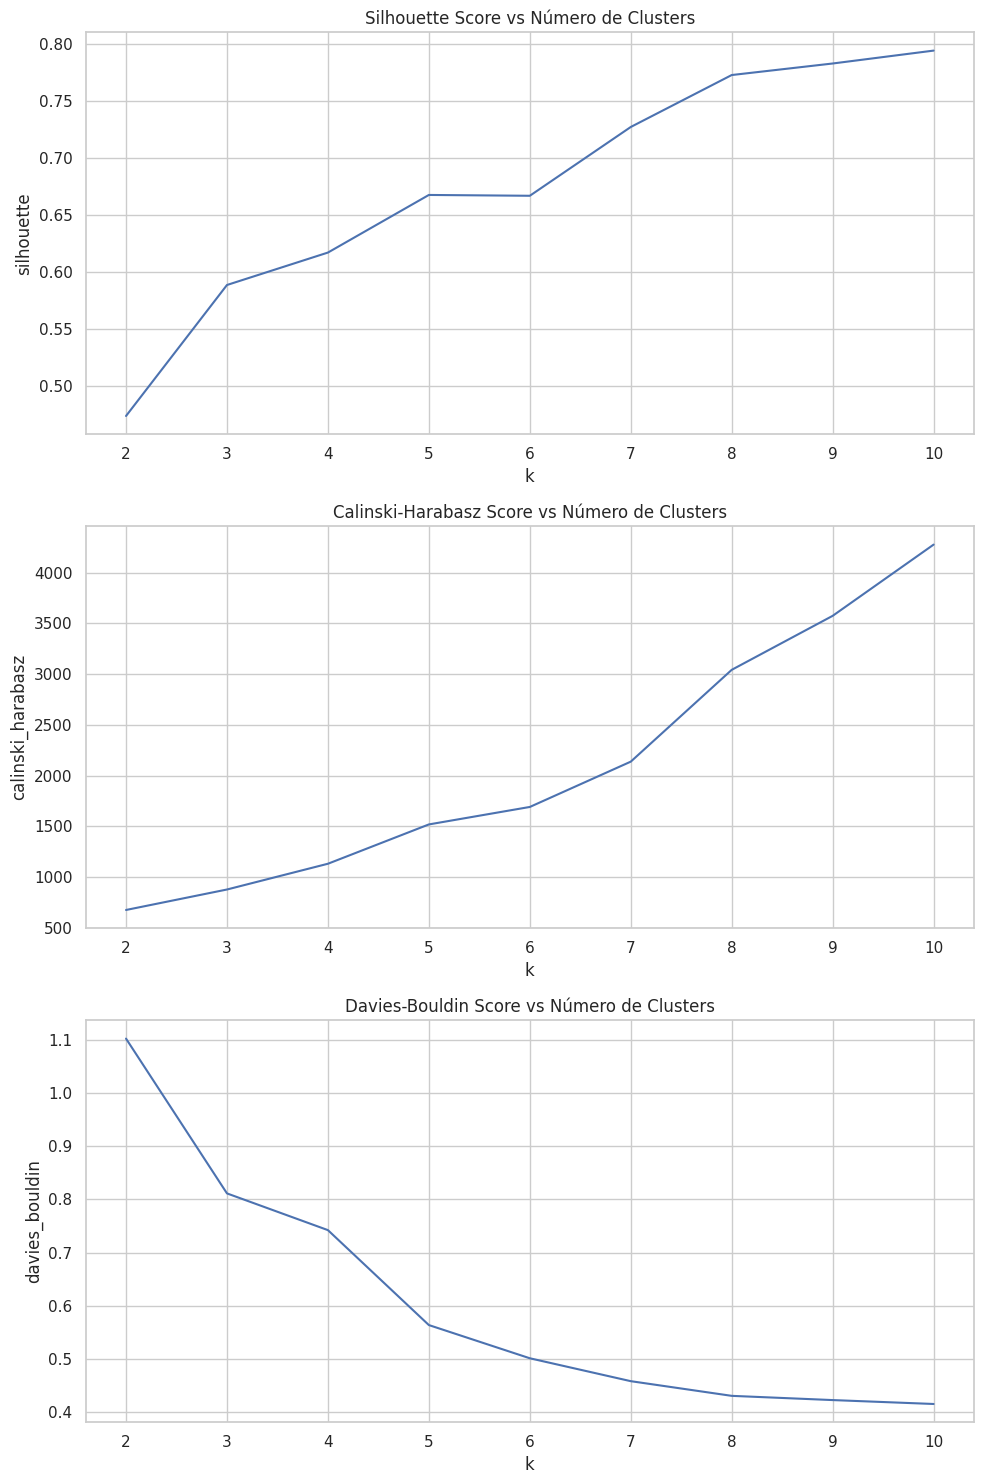

In [ ]:
plot_scores(X)

In [ ]:
# kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto')
kmeans = KMeans().set_params(**grid_search_kmeans.best_params_)
kmeans.set_params(n_clusters=10).fit_predict(X)

labels = kmeans.fit_predict(X)

## O índice **Calinski-Harabasz** (CH), também conhecido como Critério Variância-Razão, é uma métrica utilizada para avaliar a qualidade de um agrupamento em algoritmos de clusterização.
## O índice CH é calculado com base na razão entre a dispersão entre os clusters e a dispersão dentro dos clusters. O índice CH para o número K de clusters em um conjunto de dados D = [d 1 , d 2 , d 3 , ... d N ] é definido como,:

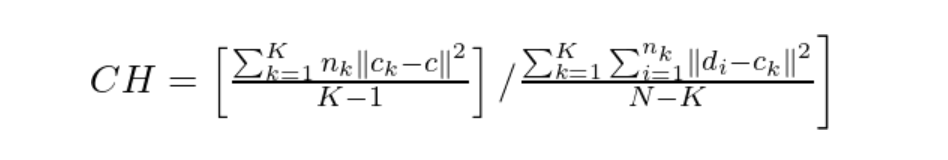

## Onde, n k   e c k  são o número de pontos de dados dos cluster k e centróide do k- ésimo cluster, respectivamente, c é o centróide global, N é o número total. de pontos de dados.

## Um valor mais alto do índice CH significa que os clusters são densos e bem separados, embora não haja um valor de corte "aceitável".



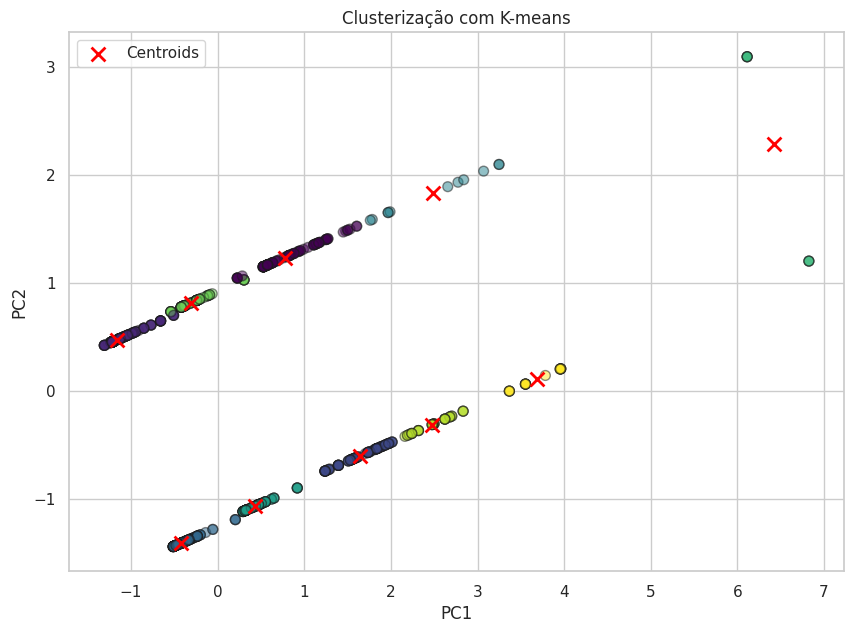

In [ ]:
plot_graph_centroid(X, labels, features)

In [ ]:
intra_distance = intra_cluster_distances(X, labels)
inter_distance = inter_cluster_distances_no_media(X, labels)
print("Distâncias Intra-Cluster:", intra_cluster_distances(X, labels))
print("Distância Inter-Cluster Média:", inter_cluster_distances(X, labels))

Distâncias Intra-Cluster: {0: 0.5055630176032474, 1: 0.1579411615787123, 2: 0.39948181967889096, 3: 0.17001472356465108, 4: 0.9515391063102348, 5: 0.19815774620101845, 6: 0.9904311720499478, 7: 0.2361321087082702, 8: 0.34190933789832506, 9: 0.39337837608843307}
Distância Inter-Cluster Média: 3.3596922431342495


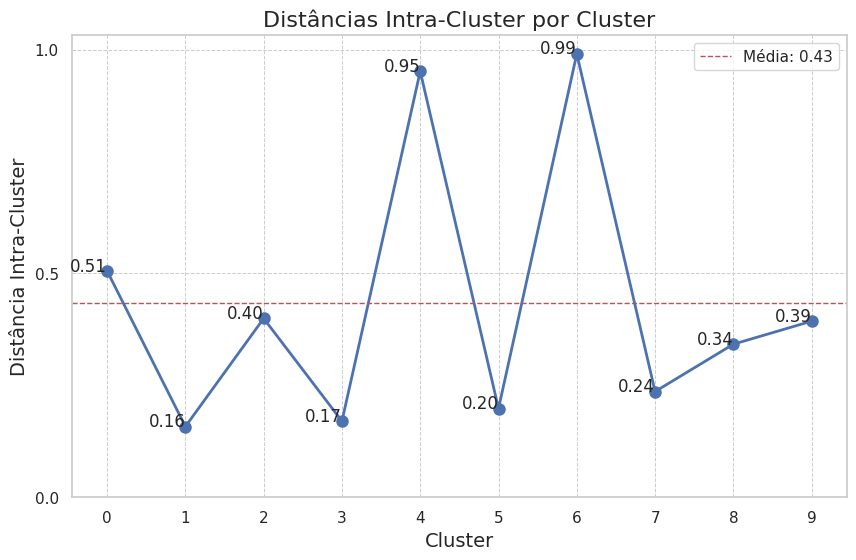

In [ ]:
import matplotlib.pyplot as plt


# Extraindo os rótulos (clusters) e os valores das distâncias
clusters = list(intra_distance.keys())
distances = list(intra_distance.values())

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(clusters, distances, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionar anotações para cada ponto
for i, (cluster, distance) in enumerate(intra_distance.items()):
    plt.text(cluster, distance, f'{distance:.2f}', fontsize=12, ha='right')

# Adicionar título e rótulos
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Distância Intra-Cluster', fontsize=14)
plt.title('Distâncias Intra-Cluster por Cluster', fontsize=16)
plt.xticks(clusters)  # Define os ticks do eixo x para os clusters
plt.yticks(np.arange(0, max(distances) + 0.5, 0.5))  # Define os ticks do eixo y
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adiciona a grade

# Adicionar uma linha horizontal na média das distâncias
mean_distance = np.mean(distances)
plt.axhline(mean_distance, color='r', linestyle='--', linewidth=1, label=f'Média: {mean_distance:.2f}')

# Adicionar a legenda
plt.legend()

# Exibir o gráfico
plt.show()

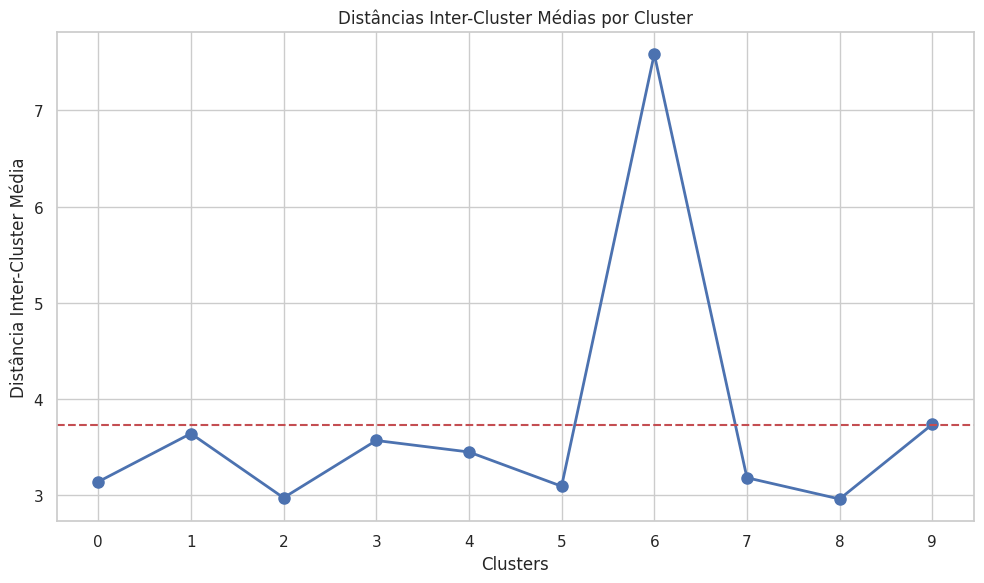

In [ ]:
clusters = list(inter_distance.keys())
average_distances = [np.mean(inter_distance[cluster]) for cluster in clusters]

# Criar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(clusters, average_distances, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Adicionar a linha de média geral
overall_mean_distance = np.mean(average_distances)
plt.axhline(y=overall_mean_distance, color='r', linestyle='--', label=f'Média Geral: {overall_mean_distance:.2f}')

# Adicionar detalhes ao gráfico
plt.xticks(ticks=clusters, labels=[f'{cluster}' for cluster in clusters])
plt.xlabel('Clusters')
plt.ylabel('Distância Inter-Cluster Média')
plt.title('Distâncias Inter-Cluster Médias por Cluster')
plt.grid(True)
plt.tight_layout()  # Ajusta o layout para caber rótulos
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)

print(loadings)

             PC1       PC2
Pclass -0.659040 -0.267475
Sex     0.352635 -0.935418
Fare    0.664315  0.231192


**Interpretação dos resultados**

* Silhouette Score: -1 a 1 -> quanto mais próximo de 1, melhor. Como obtivemos o resultado 0.29, indica uma separação fraca entre os clusters.

* Davis Bouldin Score: 0 a ∞ -> valores mais baixos indicam melhores formados e mais separados estão os clusters

* Índice BIC: Valores BIC mais negativos indicam melhor ajuste do modelo. As variáveis Pclass, SibSp e Embarked contribuem mais na formação do cluster.



Silhouette Score:  0.7911136966435711
Davis Bouldin Score:  0.40417481667477395
Índice Calinski-Harabasz: 4030.900886877182
Índice BIC
-1206.7457310969342
Relação de valores de inércia e números de clusters
Clusters: 1, Inertia: 3294.0000000000036
Clusters: 2, Inertia: 2046.9245849963422
Clusters: 3, Inertia: 1265.4298935058423
Clusters: 4, Inertia: 932.0385298307996
Clusters: 5, Inertia: 502.2950721217954
Clusters: 6, Inertia: 383.3505932176365
Clusters: 7, Inertia: 285.91787258826724
Clusters: 8, Inertia: 161.77979055510352
Clusters: 9, Inertia: 120.87365906220258
Clusters: 10, Inertia: 90.58524255454164
Clusters: 11, Inertia: 73.58033476525085
Clusters: 12, Inertia: 61.893856392835424
Clusters: 13, Inertia: 54.884123268816595
Clusters: 14, Inertia: 45.308838051812856
Ellbow Análise None


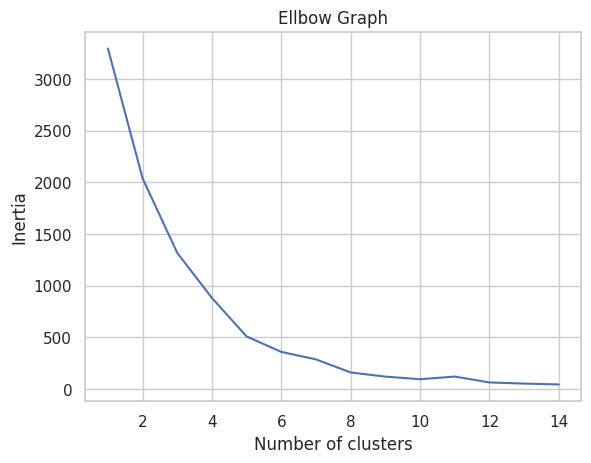

In [ ]:
print('Silhouette Score: ', silhouette(X, labels))
print('Davis Bouldin Score: ', davies_bouldin(X, labels))
print(f'Índice Calinski-Harabasz: { metrics.calinski_harabasz_score(X, labels)}')
print(f'Índice BIC\n{bic_score(X, labels)}')
print("Ellbow Análise",inertia_kmeans(X)) ## inercia entre os dados
ellbow_graph(kmeans)

In [ ]:
features = ['Pclass', 'Sex', 'Fare']

scaler = StandardScaler()
X = scaler.fit_transform(titanic_feature[['Pclass', 'Sex', 'Fare']].values)

In [ ]:
# kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto')
kmeans = KMeans().set_params(**grid_search_kmeans.best_params_)
kmeans.set_params(n_clusters=4).fit_predict(X)

labels = kmeans.fit_predict(X)

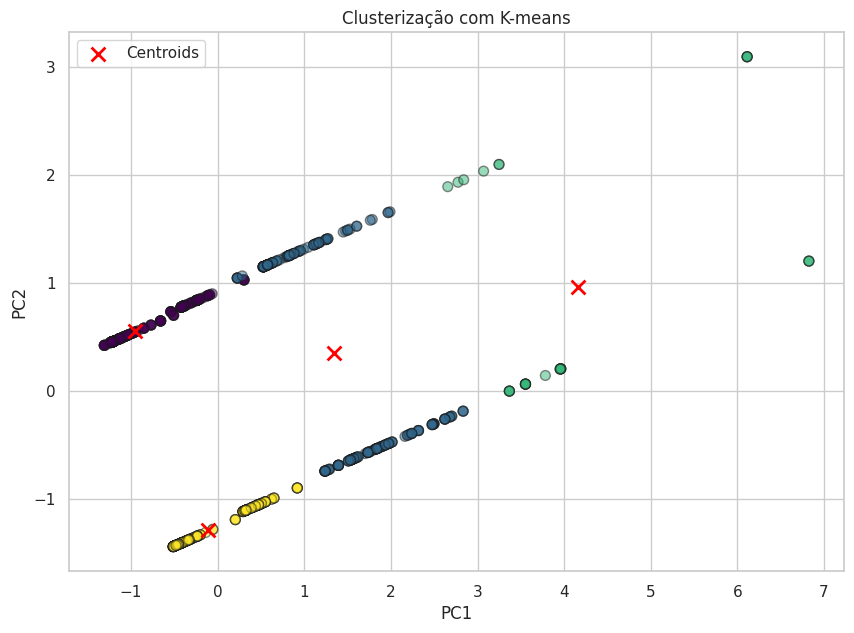

In [ ]:
plot_graph_centroid(X, labels, features)

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)

print(loadings)

             PC1       PC2
Pclass -0.659040 -0.267475
Sex     0.352635 -0.935418
Fare    0.664315  0.231192


In [ ]:
print("Distâncias Intra-Cluster:", intra_cluster_distances(X, labels))
print("Distância Inter-Cluster Média:", inter_cluster_distances(X, labels))

Distâncias Intra-Cluster: {0: 0.5463398812045137, 1: 1.4462281830799943, 2: 2.397353262020225, 3: 0.6486731996159684}
Distância Inter-Cluster Média: 2.710738986404242


Silhouette Score:  0.617104382940294
Davis Bouldin Score:  0.74221269889633
Índice Calinski-Harabasz: 1131.4317400839175
Índice BIC
-3778.876383992871
Relação de valores de inércia e números de clusters
Clusters: 1, Inertia: 3294.0000000000036
Clusters: 2, Inertia: 2046.9245849963422
Clusters: 3, Inertia: 1265.4298935058423
Clusters: 4, Inertia: 932.0385298307996
Clusters: 5, Inertia: 502.2950721217954
Clusters: 6, Inertia: 383.3505932176365
Clusters: 7, Inertia: 285.91787258826724
Clusters: 8, Inertia: 161.77979055510352
Clusters: 9, Inertia: 120.87365906220258
Clusters: 10, Inertia: 90.58524255454164
Clusters: 11, Inertia: 73.58033476525085
Clusters: 12, Inertia: 61.893856392835424
Clusters: 13, Inertia: 54.884123268816595
Clusters: 14, Inertia: 45.308838051812856
Ellbow Análise None


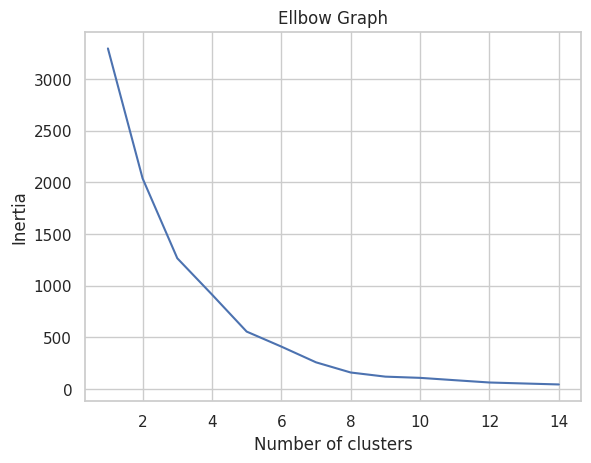

In [ ]:
print('Silhouette Score: ', silhouette(X, labels))
print('Davis Bouldin Score: ', davies_bouldin(X, labels))
print(f'Índice Calinski-Harabasz: { metrics.calinski_harabasz_score(X, labels)}')
print(f'Índice BIC\n{bic_score(X, labels)}')
print("Ellbow Análise",inertia_kmeans(X)) ## inercia entre os dados
ellbow_graph(kmeans)

In [ ]:
features = ['Pclass', 'Sex', 'Fare']

scaler = StandardScaler()
X = scaler.fit_transform(titanic_feature[['Pclass', 'Sex', 'Fare']].values)

In [ ]:
# kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto')
kmeans = KMeans().set_params(**grid_search_kmeans.best_params_)
kmeans.set_params(n_clusters=5).fit_predict(X)

labels = kmeans.fit_predict(X)

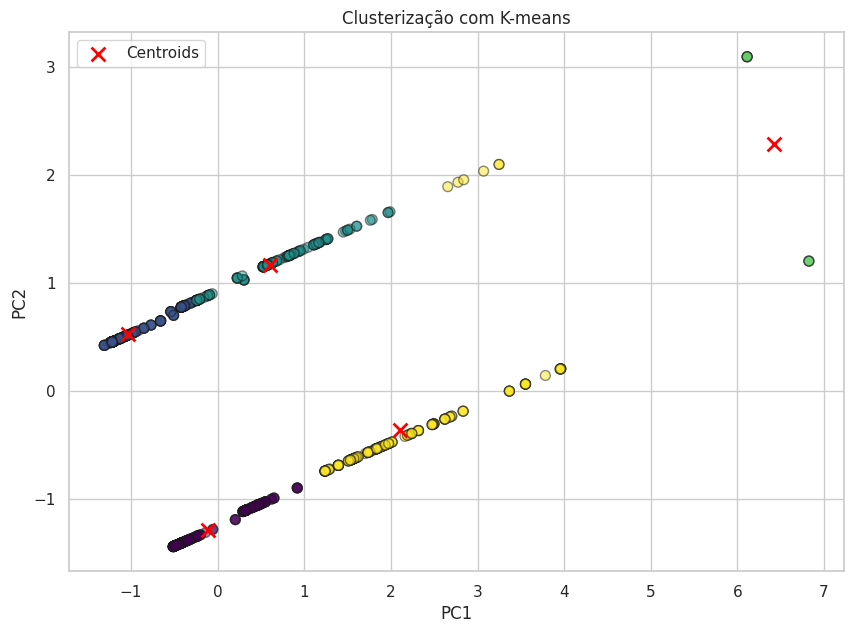

In [ ]:
plot_graph_centroid(X, labels, features)

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)

print(loadings)

             PC1       PC2
Pclass -0.659040 -0.267475
Sex     0.352635 -0.935418
Fare    0.664315  0.231192


In [ ]:
print("Distâncias Intra-Cluster:", intra_cluster_distances(X, labels))
print("Distância Inter-Cluster Média:", inter_cluster_distances(X, labels))

Distâncias Intra-Cluster: {0: 0.6486731996159684, 1: 0.44877297453656406, 2: 0.8257054776886258, 3: 0.9904311720499478, 4: 1.278740176438733}
Distância Inter-Cluster Média: 3.8058327542281325


Silhouette Score:  0.6453627824382558
Davis Bouldin Score:  0.570777554697314
Índice Calinski-Harabasz: 1380.0742862846878
Índice BIC
-3562.614129519625
Relação de valores de inércia e números de clusters
Clusters: 1, Inertia: 3294.0000000000036
Clusters: 2, Inertia: 2046.9245849963422
Clusters: 3, Inertia: 1265.4298935058423
Clusters: 4, Inertia: 932.0385298307996
Clusters: 5, Inertia: 502.2950721217954
Clusters: 6, Inertia: 383.3505932176365
Clusters: 7, Inertia: 285.91787258826724
Clusters: 8, Inertia: 161.77979055510352
Clusters: 9, Inertia: 120.87365906220258
Clusters: 10, Inertia: 90.58524255454164
Clusters: 11, Inertia: 73.58033476525085
Clusters: 12, Inertia: 61.893856392835424
Clusters: 13, Inertia: 54.884123268816595
Clusters: 14, Inertia: 45.308838051812856
Ellbow Análise None


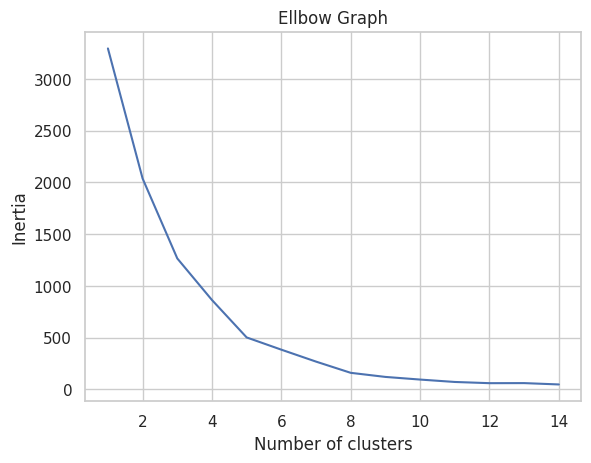

In [ ]:
print('Silhouette Score: ', silhouette(X, labels))
print('Davis Bouldin Score: ', davies_bouldin(X, labels))
print(f'Índice Calinski-Harabasz: { metrics.calinski_harabasz_score(X, labels)}')
print(f'Índice BIC\n{bic_score(X, labels)}')
print("Ellbow Análise",inertia_kmeans(X)) ## inercia entre os dados
ellbow_graph(kmeans)

# DBScan

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo que identifica clusters em dados com base na densidade dos pontos.

Ele classifica os pontos em três categorias: pontos centrais (em regiões de alta densidade), pontos de borda (próximos a pontos centrais) e ruído (pontos isolados).

Dois parâmetros principais, eps (a distância máxima entre dois pontos para serem considerados vizinhos) e min_samples (o número mínimo de pontos necessários para formar um cluster).

DBSCAN é eficaz em identificar clusters com forma arbitrária e detectar outliers, sendo útil em cenários onde existem ruído nos dados.

**Seleção de parâmetros**

**minPts**: o *minPts* mínimo pode ser derivado do número de dimensões *D* no conjunto de dados, como **`minPts ≥ D + 1`**.
  - valores maiores são geralmente melhores para conjuntos de dados com ruído e produzirão clusters mais significativos. Como regra geral, **`minPts = 2·dim`** pode ser usado, mas pode ser necessário escolher valores maiores para dados muito grandes, dados ruidosos ou dados que contêm muitos duplicados.

**ε**: O valor de ε pode ser escolhido usando um gráfico de k-distance, plotando a distância para o **`k = minPts - 1`**vizinho mais próximo ordenado do maior para o menor valor. Bons valores de ε são onde este gráfico mostra um “cotovelo”:
  - se ε for escolhido muito pequeno, uma grande parte dos dados não será agrupada; enquanto que, para um valor muito alto de ε, os clusters se fundirão e a maioria dos objetos estará no mesmo cluster.

**Impacto dos parâmetros**

- **Valores pequenos de `eps`**: Resultam em muitos pequenos clusters ou em muitos pontos sendo considerados como ruído (outliers).
- **Valores grandes de `eps`**: Resultam em poucos clusters grandes, pois os clusters se fundirão, podendo incluir pontos que não estão tão próximos, diluindo a definição dos clusters.

- **Valores pequenos de `min_samples`**: Resultam em muitos pequenos clusters, potencialmente formando clusters com outliers.
- **Valores grandes de `min_samples`**: Requer mais pontos para formar um cluster, resultando em menos clusters e de maiores tamanhos, com mais pontos sendo considerados ruído.

A combinação dos valores de `eps` e `min_samples` determina a densidade necessária para formar clusters:

- **Alta densidade (`eps` pequeno e `min_samples` grande)**: Forma clusters apenas em regiões de alta densidade, com muitos pontos sendo considerados ruído.
- **Baixa densidade (`eps` grande e `min_samples` pequeno)**: Forma clusters em regiões de baixa densidade, com menos pontos considerados ruído.

In [ ]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(titanic_feature[['Fare','Pclass','Sex']].values)
# dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan = DBSCAN().set_params(**study_dbscan.best_params)
outliers = dbscan.fit_predict(scaled_values)
dbscan_score(outliers, scaled_values)

Número estimado de clusters: 16
Número estimado de pontos de ruído: 0
Coeficiente de Silhueta: 0.714


In [ ]:
print("Distâncias Intra-Cluster:", intra_cluster_distances(scaled_values, outliers))
print("Distância Inter-Cluster Média:", inter_cluster_distances(scaled_values, outliers))

Distâncias Intra-Cluster: {0: 0.15794116094350188, 1: 0.721010681243858, 2: 0.14578452483641824, 3: 0.5606451859558533, 4: 0.1564333299861018, 5: 0.17053679796837648, 6: 0.11897655147646306, 7: 0.0, 8: 0.061598731867855236, 9: 0.0, 10: 0.0, 11: 0.024019440498471527, 12: 0.12317169087617014, 13: 0.13437435792465285, 14: 0.0, 15: 0.0}
Distância Inter-Cluster Média: 3.6782268878502817


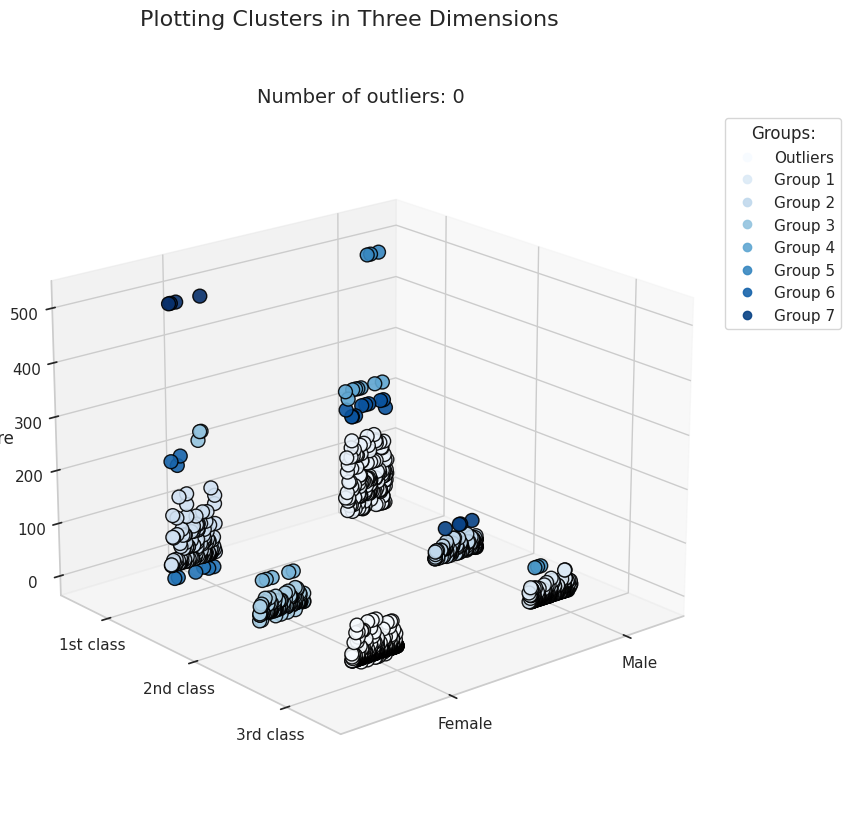

In [ ]:
plt.figure(figsize=(9,10))

plt.subplots_adjust(top=0.95)
plt.suptitle('Plotting Clusters in Three Dimensions', fontsize=16)

ax = plt.axes(projection='3d')
ax.view_init(20, 50), ax.invert_xaxis()

ax.set_title(f'Number of outliers: {dbscan.labels_[dbscan.labels_ == -1].size}', fontsize=14)
ax.set_xticks([0,1]), ax.set_xmargin(m=0.25), ax.set_xticklabels(['Female','Male'])
ax.set_yticks([1,2,3]), ax.set_ymargin(m=0.25), ax.set_yticklabels(['1st class','2nd class','3rd class'])
ax.set_zlabel('Fare')

g = ax.scatter(titanic_feature['Sex']-0.25*np.random.rand(len(titanic_feature['Sex'])), titanic_feature['Pclass'], titanic_feature['Fare'], c=outliers,
               cmap='Blues', s=100, edgecolor='black', linewidth=1, depthshade=0, alpha=0.9)

handles, labels = g.legend_elements()
plt.legend([handles[i] for i in range(len(handles))],['Outliers']+['Group '+str(i) for i in range(1,len(labels))],title='Groups:',
           bbox_to_anchor=(0,0,1.2,1))
plt.show()

Considerando Age, sem agrupamento

In [ ]:

scaler = StandardScaler()
scaled_values = scaler.fit_transform(titanic_feature[['Pclass', 'Sex', 'Age']].values)

# dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan = DBSCAN().set_params(**study_dbscan.best_params)
outliers = dbscan.fit_predict(scaled_values)
dbscan_score(outliers, scaled_values)

Número estimado de clusters: 18
Número estimado de pontos de ruído: 0
Coeficiente de Silhueta: 1.000


In [ ]:
print("Distâncias Intra-Cluster:", intra_cluster_distances(scaled_values, outliers))
print("Distância Inter-Cluster Média:", inter_cluster_distances(scaled_values, outliers))

Distâncias Intra-Cluster: {0: 2.0949462936297335e-08, 1: 0.0, 2: 2.9523796010240216e-08, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 2.9154445814049763e-08, 9: 2.070371505798304e-08, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0}
Distância Inter-Cluster Média: 2.344318644549687


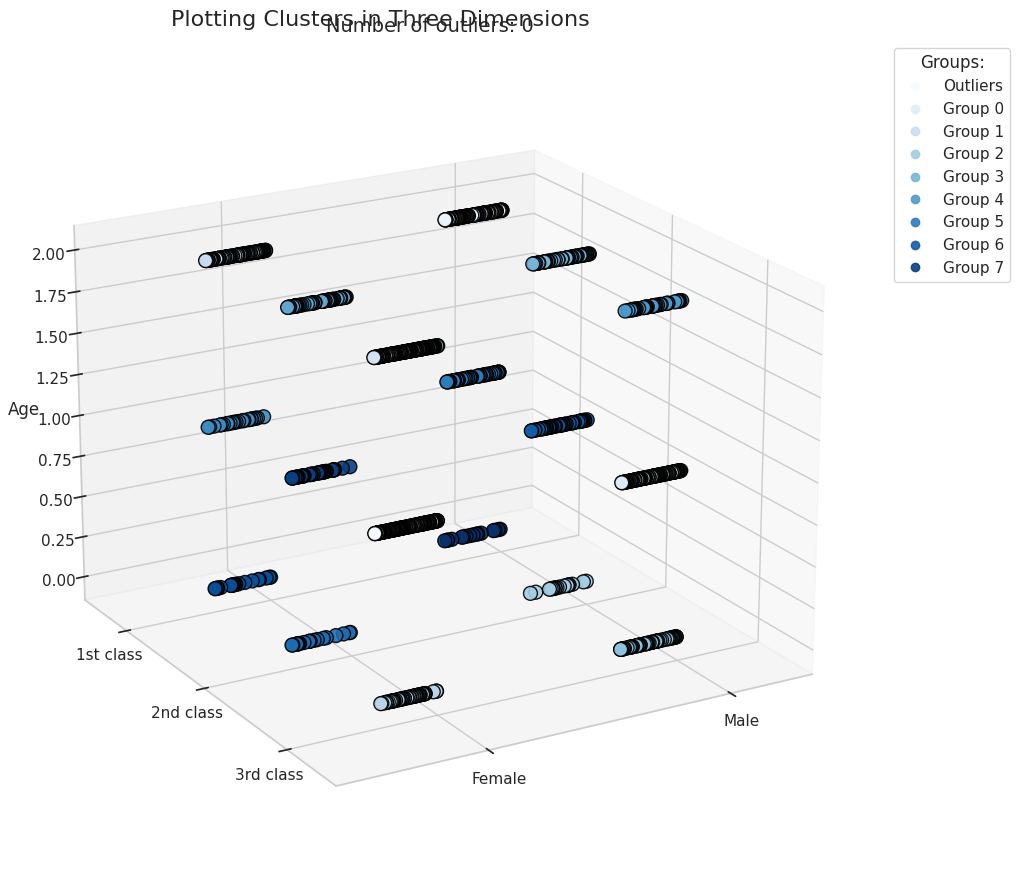

In [ ]:
plt.figure(figsize=(40, 10))
plt.subplots_adjust(top=0.95)
plt.suptitle('Plotting Clusters in Three Dimensions', fontsize=16)

ax = plt.axes(projection='3d')
ax.view_init(20, 60)
ax.invert_xaxis()

ax.set_title(f'Number of outliers: {dbscan.labels_[dbscan.labels_ == -1].size}', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xmargin(m=0.25)
ax.set_xticklabels(['Female', 'Male'])
ax.set_yticks([1, 2, 3])
ax.set_ymargin(m=0.25)
ax.set_yticklabels(['1st class', '2nd class', '3rd class'])
ax.set_zlabel('Age')

g = ax.scatter(
    titanic_feature['Sex'] - 0.25 * np.random.rand(len(titanic_feature['Sex'])),
    titanic_feature['Pclass'],
    titanic_feature['Age'],
    c=outliers,
    cmap='Blues',
    s=100,
    edgecolor='black',
    linewidth=1,
    depthshade=0,
    alpha=0.9
)


handles, labels = g.legend_elements()
legend_labels = ['Outliers'] + [f'Group {i}' for i in range(len(labels) - 1)]

plt.legend(
    [handles[i] for i in range(len(handles))],
    legend_labels,
    title='Groups:',
    bbox_to_anchor=(0, 0, 1.2, 1)
)

plt.show()
